# 필요한 모듈을 가져오고 데이터를 로드합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 16-02-04 ~ 21-02-04

df = pd.read_csv('C:\Jupyter_Project\HY.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6300,7100,6300,7000,1619.266357,56800
1,2000-01-05,6700,7100,6610,6700,1549.868774,52100
2,2000-01-06,7000,7000,6250,6300,1457.339844,64900
3,2000-01-07,6350,6600,6300,6370,1473.532349,61800
4,2000-01-10,6610,6700,6300,6500,1503.603882,56100


In [3]:
ratio = df['Adj Close']/df['Close']

ratio

0       0.231324
1       0.231324
2       0.231324
3       0.231324
4       0.231324
          ...   
5294    1.000000
5295    1.000000
5296    1.000000
5297    1.000000
5298    1.000000
Length: 5299, dtype: float64

In [4]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [5]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [6]:
df.rename(columns={'Adj Open' : 'Open', 'Adj High' : 'High', 'Adj Low' : 'Low', 'Adj Close' : 'Close'}, inplace=True)

In [7]:
# 과거의 절대 가격도 현재 가격의 시점으로 보기 위해 수정 가격을 사용한다
# 현재 시점으로 과거 가격에다 과거 발생한 액면분할(stock split)과 현금배당(cash dividends)을 
# 반영한 가격이 수정가격(adjusted price)이다. 따라서 OHLC -> adj_OHLC로 바꿔 준다

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,1457.339721,1642.398734,1457.339721,1619.266357,56800
1,1549.868774,1642.398253,1529.049641,1549.868774,52100
2,1619.266493,1619.266493,1445.773655,1457.339844,64900
3,1468.905874,1526.736814,1457.339686,1473.532349,61800
4,1529.049486,1549.868617,1457.339147,1503.603882,56100
...,...,...,...,...,...
5294,9200.000000,9480.000000,9100.000000,9380.000000,81355
5295,9460.000000,9810.000000,9460.000000,9700.000000,105755
5296,9850.000000,10200.000000,9800.000000,9990.000000,170966
5297,10100.000000,10200.000000,9940.000000,10150.000000,133504


# Normalization을 진행합니다

In [8]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.068903  0.079631  0.070081  0.082280  0.020308
1     0.076665  0.079631  0.076089  0.076473  0.018627
2     0.082487  0.077801  0.069112  0.068730  0.023204
3     0.069873  0.070480  0.070081  0.070085  0.022095
4     0.074918  0.072310  0.070081  0.072601  0.020057
...        ...       ...       ...       ...       ...
5294  0.718436  0.699782  0.710414  0.731697  0.029087
5295  0.740248  0.725893  0.740577  0.758474  0.037810
5296  0.772965  0.756752  0.769063  0.782742  0.061125
5297  0.793938  0.756752  0.780793  0.796130  0.047732
5298  0.802327  0.804227  0.798388  0.837970  0.088390

[5299 rows x 5 columns]


# 데이터를 분할하여 훈련 데이터를 생성합니다

In [9]:
# 20일 학습하고 그 다음날 종가예측
# 테스트 기간은 40일, 따라서 1221-40 : train / 40 : test

window_size = 20
TEST_SIZE = 21

In [10]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [11]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
np.array(label_list)

NameError: name 'label_list' is not defined

# train data를 split하여 validation set을 만든다

In [14]:
test

,Open,High,Low,Close,Volume
5278,0.745281,0.706903,0.736387,0.742575,0.038455
5279,0.746959,0.752796,0.746442,0.757638,0.140303
5280,0.772965,0.729058,0.743928,0.755964,0.043703
5281,0.761220,0.721937,0.753982,0.761822,0.018468
5282,0.765415,0.723520,0.756496,0.765169,0.018569
5283,0.767093,0.727476,0.745604,0.747596,0.030688
5284,0.748637,0.706903,0.728009,0.727513,0.026529
5285,0.729342,0.706903,0.727171,0.727513,0.035990
5286,0.731859,0.695826,0.721306,0.724166,0.022289
5287,0.727664,0.699782,0.723820,0.740065,0.028646


In [15]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train set : 모델을 학습하는 유일한 dataset
# validation set : 학습이 이미 완료된 모델을 검증하기 위한 dataset 

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((928, 20, 4), (240, 20, 4))

# test dataset : 학습과 검증이 완료된 모델의 성능을 평가하기 위한 dataset
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((21, 4), (21, 1))

In [17]:
x_train.shape

(4206, 20, 4)

In [18]:
x_valid.shape

(1052, 20, 4)

In [19]:
test_feature.shape

(21, 4)

In [20]:
test_label.shape

(21, 1)

In [153]:
train_label

array([[0.32662257],
       [0.31529592],
       [0.31529592],
       ...,
       [0.79663866],
       [0.78991597],
       [0.84033613]])

In [154]:
x_train.shape

(944, 20, 4)

In [155]:
x_valid.shape

(236, 20, 4)

In [156]:
y_train.shape

(944, 1)

In [157]:
y_valid.shape

(236, 1)

In [158]:
test_label

,Close
1200,0.857143
1201,0.858824
1202,0.889076
1203,0.885714
1204,0.897479
1205,0.904202
1206,0.868908
1207,0.828571
1208,0.828571
1209,0.821849


In [21]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)

test_feature.shape, test_label.shape
# ((40-20, 20, 4), (40-20, 1))

((1, 20, 4), (1, 1))

In [22]:
test_feature

array([[[0.74528134, 0.70690331, 0.7363875 , 0.03845472],
        [0.74695915, 0.75279584, 0.74644159, 0.14030286],
        [0.77296514, 0.72905833, 0.74392806, 0.04370252],
        [0.7612205 , 0.72193707, 0.75398216, 0.01846815],
        [0.76541501, 0.72351957, 0.75649568, 0.01856933],
        [0.76709282, 0.72747583, 0.74560375, 0.03068848],
        [0.74863696, 0.70690331, 0.72800909, 0.02652863],
        [0.72934219, 0.70690331, 0.72717125, 0.03598991],
        [0.7318589 , 0.69582581, 0.72130636, 0.0222887 ],
        [0.72766439, 0.69978206, 0.72381988, 0.02864627],
        [0.7318589 , 0.72272832, 0.73219829, 0.04667144],
        [0.76373721, 0.75279584, 0.76152273, 0.08458915],
        [0.79393771, 0.78048961, 0.79419852, 0.05100898],
        [0.82749382, 0.78444586, 0.79000932, 0.05193248],
        [0.77799855, 0.73380583, 0.7405767 , 0.07200521],
        [0.74779805, 0.70927706, 0.71460363, 0.05017093],
        [0.71843646, 0.69978206, 0.71041443, 0.02908675],
        [0.740

In [23]:
test_label

array([[0.83797022]])

In [160]:
test_feature

array([[[0.84349259, 0.8238255 , 0.88111888, 0.03624805],
        [0.83855025, 0.82718121, 0.87937063, 0.03845472],
        [0.84184514, 0.92449664, 0.90034965, 0.14030286],
        [0.89291598, 0.87416107, 0.8951049 , 0.04370252],
        [0.86985173, 0.8590604 , 0.91608392, 0.01846815],
        [0.87808896, 0.86241611, 0.92132867, 0.01856933],
        [0.88138386, 0.87080537, 0.8986014 , 0.03068848],
        [0.84514003, 0.82718121, 0.86188811, 0.02652863],
        [0.80724876, 0.82718121, 0.86013986, 0.03598991],
        [0.8121911 , 0.80369128, 0.8479021 , 0.0222887 ],
        [0.80395387, 0.81208054, 0.85314685, 0.02864627],
        [0.8121911 , 0.86073826, 0.87062937, 0.04667144],
        [0.87479407, 0.92449664, 0.93181818, 0.08458915],
        [0.93410214, 0.98322148, 1.        , 0.05100898],
        [1.        , 0.99161074, 0.99125874, 0.05193248],
        [0.90280066, 0.88422819, 0.88811189, 0.07200521],
        [0.84349259, 0.83221477, 0.83391608, 0.05017093],
        [0.785

In [161]:
test_label

array([[0.96638655]])

# 딥러닝  네트워크를 학습시킵니다

In [162]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [163]:
# val_loss가 10회 같을 시 early_stop, batch_size(=K)는 K문제 풀고 답보고 하는 식

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=1,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
944/944 [==============================] - 5s 4ms/step - loss: 0.0296 - val_loss: 0.0018

Epoch 00001: val_loss improved from inf to 0.00183, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 2/200
944/944 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0013

Epoch 00002: val_loss improved from 0.00183 to 0.00128, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 3/200
944/944 [==============================] - 3s 4ms/step - loss: 9.6742e-04 - val_loss: 5.4368e-04

Epoch 00003: val_loss improved from 0.00128 to 0.00054, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 4/200
944/944 [==============================] - 3s 3ms/step - loss: 7.2450e-04 - val_loss: 9.8359e-04

Epoch 00004: val_loss did not improve from 0.00054
Epoch 5/200
944/944 [==============================] - 

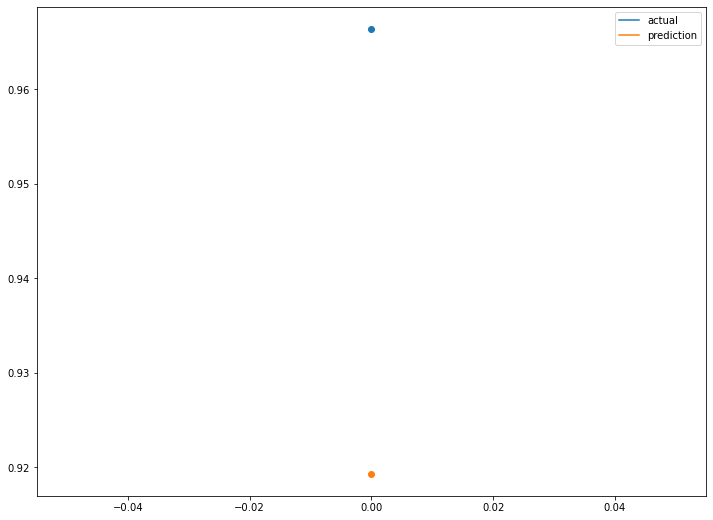

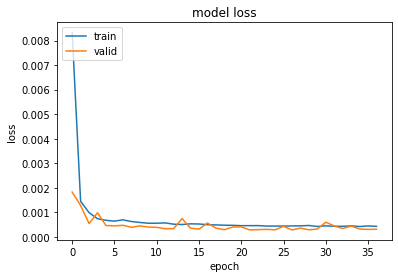

In [165]:
pred = model.predict(test_feature)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(test_label), label='actual')
plt.plot(pred, label='prediction')
x_values = list(range(1))

plt.scatter(x_values, np.asarray(test_label))
plt.scatter(x_values, pred)
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [166]:
TEST_SIZE

21

In [167]:
pred = model.predict(test_feature)
pred.shape

(1, 1)

In [168]:
B=pred
B

array([[0.9193067]], dtype=float32)

In [178]:
A = test_feature[:,]
A

array([[[0.84349259, 0.8238255 , 0.88111888, 0.03624805],
        [0.83855025, 0.82718121, 0.87937063, 0.03845472],
        [0.84184514, 0.92449664, 0.90034965, 0.14030286],
        [0.89291598, 0.87416107, 0.8951049 , 0.04370252],
        [0.86985173, 0.8590604 , 0.91608392, 0.01846815],
        [0.87808896, 0.86241611, 0.92132867, 0.01856933],
        [0.88138386, 0.87080537, 0.8986014 , 0.03068848],
        [0.84514003, 0.82718121, 0.86188811, 0.02652863],
        [0.80724876, 0.82718121, 0.86013986, 0.03598991],
        [0.8121911 , 0.80369128, 0.8479021 , 0.0222887 ],
        [0.80395387, 0.81208054, 0.85314685, 0.02864627],
        [0.8121911 , 0.86073826, 0.87062937, 0.04667144],
        [0.87479407, 0.92449664, 0.93181818, 0.08458915],
        [0.93410214, 0.98322148, 1.        , 0.05100898],
        [1.        , 0.99161074, 0.99125874, 0.05193248],
        [0.90280066, 0.88422819, 0.88811189, 0.07200521],
        [0.84349259, 0.83221477, 0.83391608, 0.05017093],
        [0.785

In [188]:
Y = A[:,19]
Y

array([[0.89291598, 0.93288591, 0.94755245, 0.06112526]])

In [199]:
q = np.insert(Y,3,B)
v = q.reshape((1,-1))
v

array([[0.89291598, 0.93288591, 0.94755245, 0.9193067 , 0.06112526]])

In [204]:
o=scaler.inverse_transform(v)
o

array([[  9850.        ,  10200.        ,   9800.        ,
          9869.87483799, 170966.        ]])

In [209]:
w = o[:,3]

w

array([9869.87483799])

In [211]:
## saving the output into a csv
prediction = int(w[[0]])
print('Predicted value for next day=',prediction, 'won')
b = df['Close'].iloc[-1]
print('last close price=',b, '원')
percentage = ((prediction-b)/b)*100
print('percentage change should be =', percentage.round(3),'%' )

Predicted value for next day= 9869 won
last close price= 10150.0 원
percentage change should be = -2.768 %
